In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

In [2]:
@pims.pipeline
def hough_preprocessing(image, x1, y1, x2, y2):    
    """
    Pims pipeline preprocessing of the image for the HoughCircles function.
    Crops the image to remove the petri dish, converts the image to grayscale and applies a median filter.

    Parameters
    ----------
    image: image
        image to preprocess.
    x1, y1, x2, y2: int
        coordinates of the circle to crop.
    Returns
    -------
    npImage: array
        image to be analyzed.
    """
    npImage = np.array(image)
    #npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2HSV)
    # Create same size alpha layer with circle
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy array
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha #npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    npImage = cv2.medianBlur(npImage, 5)
    return npImage

	
def hough_loc_frame(correct_n, frame, img, parameters):
	"""
	Hough transform to locate the droplets in the frame.

	Parameters
	----------
	correct_n: int
		number of droplets in the frame.
	frame: int
		frame to be analyzed.
	img: image
		image for the HoughCircles function.
	parameters: dict
		parameters for the HoughCircles function.
	
	Returns
	-------
	if found_circles is not None and the number of droplets found is equal to correct_n:
		x, y position of the droplets, diameter of the droplets, frame, correct_n.
	if found_circles is not None and the number of droplets found is not equal to correct_n:
		x, y position (0,0), diameter of the droplets (0), frame, number of droplets found.
	else:
		x, y position (0,0), diameter of the droplets (0), frame, 0.
	"""
	found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	return np.hstack((found_circles[0], (np.ones((found_circles.shape[1], 1), dtype=int)*frame),\
						  np.ones((found_circles.shape[1], 1), dtype=int)*found_circles.shape[1]))
	"""
	if (found_circles is not None) and (found_circles.shape[1] == correct_n):
		return np.hstack((found_circles[0], (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.ones((correct_n, 1), dtype=int)*correct_n))
	elif (found_circles is not None) and (found_circles.shape[1] != correct_n):
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.ones((correct_n, 1), dtype=int)*found_circles.shape[1]))
	else:
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.zeros((correct_n, 1), dtype=int)))
	"""

def hough_feature_location(data_preload, frames, correct_n, params, progress_verb):
	"""
	Locates the droplets in the frames using the HoughCircles function.
	N.B. Uses cv2.HOUGH_GRADIENT_ALT method, check for the parameters in the OpenCV documentation.

	Parameters
	----------
	data_preload: list
		list of images to be analyzed.
	frames: array
		frames to be analyzed.
	correct_n: int
		number of droplets in the frame.
	params: dict
		parameters for the HoughCircles function.
	progress_verb: bool
		if True, shows the progress bar.

	Returns
	-------
	temp: dataframe
		dataframe with the x, y, d, frame, nDroplets of the found circles in the frames.
	err_frames: array
		frames where the number of droplets found is different from the correct_n.
	loss: float
		percentage of frames where the number of droplets found is different from the correct_n.
	"""
	if progress_verb:
		temp = []
		for i in tqdm(range(len(frames))):
			temp.append(hough_loc_frame(correct_n, frames[i], data_preload[i], params))
	else:
		temp = []
		for i in range(len(frames)): 
			temp.append(hough_loc_frame(correct_n, frames[i], data_preload[i], params))

	temp = pd.DataFrame(np.array(temp).reshape(len(frames)*correct_n, 5), columns = ["x", "y", "d", "frame", "nDroplets"])
	err_frames = temp.loc[temp.nDroplets != correct_n].frame.unique().astype(int)
	loss = err_frames.shape[0]/frames.shape[0]
	return temp, err_frames, loss

def optimize_params(x, *args):
	"""
	Optimizes the parameters for the HoughCircles function and saves the set of parameters with the best score.
	N.B. Uses cv2.HOUGH_GRADIENT_ALT method, check for the parameters in the OpenCV documentation.

	Parameters
	----------
	x: array
		parameters for the HoughCircles function.
	args: tuple
		data_preload, frames, correct_n, traj_part.
	
	Returns
	-------
	loss: float
		percentage of frames where the number of droplets found is different from the correct_n.
	"""
	data_preload, frames, correct_n, traj_part = args
	params = {"dp":x[0], "minDist":int(x[1]), "param1":x[2], "param2":x[3], "minRadius":int(x[4]), "maxRadius":int(x[5])}
	errs = 0
	for frame in tqdm(frames):
		found_circles = cv2.HoughCircles(data_preload[frame], cv2.HOUGH_GRADIENT_ALT, **params)
		if (found_circles is not None) and (found_circles.shape[1] == correct_n):
			pass
		else:
			errs += 1
	loss = errs/frames.shape[0]

	# Save the current best score and set of parameters to a CSV file
	a = [loss, x[0], int(x[1]), x[2], x[3], int(x[4]), int(x[5])]
	with open(f"./results/tracking_data/hough/{traj_part}_opt.csv", mode = 'a', newline='') as file:
	   writer = csv.writer(file)
	   writer.writerow(a)
	print(a)
	return loss
	

def plot_opt_results(opt_result_df, slot2):
	"""
	Plots the loss and the parameter slot2.
	
	Parameters
	----------
	opt_result_df: dataframe
		dataframe with the loss and the parameters.
	slot2: str
		parameter to be plotted.
	
	Returns
	-------
	fig: figure
		figure with the loss and the parameter slot2.
	"""
	
	fig, ax = plt.subplots(1, 1)
	ax.plot(np.arange(0, len(opt_result_df.loss), 1), opt_result_df.loss, 'b-')
	ax.set_ylabel("loss", color = 'b') 
	ax1 = ax.twinx() 
	ax1.plot(np.arange(0, len(opt_result_df[slot2]), 1), opt_result_df[slot2], 'r.')
	ax1.set_ylabel(slot2, color='r')
	ax.grid()
	plt.show()
	return fig

In [3]:
# SETUP
preload_load_data = True # takes 20 min
merge_frame = 32269 
data = hough_preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
if preload_load_data: 
    data_preload = list(data[:merge_frame])

traj_part = "pre_merge"
startFrame = 0
endFrame = merge_frame
frames = np.arange(startFrame, endFrame, 1)
correct_n = 50
default_parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}

deprecated pixel format used, make sure you did set range correctly


In [ ]:
# choose which trajectory part to run --> "pre_merge" or "post_merge"
traj_part = "pre_merge"

optimization_verb = True
run_optimization_verb = False 
if optimization_verb:
    if run_optimization_verb:
        if not os.path.exists(f"./results/tracking_data/hough/{traj_part}_optimization.csv"):
            # initialize the CSV file with the header if it does not exist
            with open(f"./results/tracking_data/hough/{traj_part}_opt.csv", mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['loss', 'dp', 'minDist', 'param1', 'param2', 'minRadius', 'maxRadius'])

        frames_opt = np.sort(random.sample(list(frames), 5000)) # randomly select 5000 frames to optimize --> change this number if needed
        # paramters of HoighCircles --> dp, minDist, param1, param2, minRadius, maxRadius
        init_guess =  [2, 8, 20, 0.8, 10, 35] # initial guess for the parameters
        params_bounds = [(1, 3), (5, 20), (20, 200), (0.3, 1), (5, 20), (20, 40)] # bounds for the parameters
        print("Starting optimization...")
        opt_result = dual_annealing(optimize_params, x0 = init_guess, args = (data_preload, frames_opt, correct_n, traj_part),\
                                    bounds = params_bounds, maxfun=100)
        print(opt_result)
    else:
        try:
            opt_result_df = pd.read_csv(f"./results/tracking_data/hough/{traj_part}_opt.csv").sort_values("loss", ascending=False)
            # the best set of parameters is the one that minimizes the loss
            optimized_parameters = {"dp": opt_result_df.iloc[-1].dp, "minDist": opt_result_df.iloc[-1].minDist,\
                                    "param1": opt_result_df.iloc[-1].param1, "param2": opt_result_df.iloc[-1].param2,\
                                    "minRadius": int(opt_result_df.iloc[-1].minRadius), "maxRadius": int(opt_result_df.iloc[-1].maxRadius)}
            parameters = optimized_parameters
            print("Optimized parameters:", parameters)
            plot_opt_results(opt_result_df, "param1")
        except:
            raise Exception("No optimization results found")
else:
    parameters = default_parameters
    print("Default parameters:", parameters)

############################################################################################################
#                                      hough feature location                                              #
############################################################################################################

run_location = False
if run_location:
    # save to txt parameters:
    with open(f'./results/tracking_data/hough/hough/hough_{traj_part}.txt', 'w') as f:
        f.write(json.dumps(parameters))
    hough_df, err_frames, error = hough_feature_location(data_preload, frames, correct_n, parameters, False)
    hough_df.to_parquet(f"./results/tracking_data/hough/hough_{traj_part}.parquet")
else:
    try:
        parameters = json.load(open(f'./results/tracking_data/hough/hough_{traj_part}.txt'))
        hough_df = pd.read_parquet(f"./results/tracking_data/hough/hough_{traj_part}.parquet")
        print(parameters)
        display(hough_df)
    except:
        raise Exception(f"No {traj_part} data found, run analysis first")

############################################################################################################
#                                       import trackpy trajectory                                          #
############################################################################################################
try:
    trackpy_df = pd.read_parquet(f"./results/tracking_data/trackpy_{traj_part}_sorted_and_colored.parquet")
except:
    raise Exception(f"No {traj_part} trackpy data found, run analysis first")
colors = trackpy_df.loc[trackpy_df.frame == 0].color.values


############################################################################################################
#                                  setup hough features dataframe                                          #
############################################################################################################
hough_df = hough_df.replace(0, np.nan)
hough_df.loc[:49, ["frame"]] = 0
if traj_part == "pre_merge":
    correct_n = 50
elif traj_part == "post_merge":
    correct_n = 49
hough_df = hough_df.loc[hough_df.frame.between(0, max(trackpy_df.frame)), :]
hough_df["particle"] = np.ones(len(hough_df), dtype=int)*(-1) # initialize particle id to -1
hough_df["flag"] = np.zeros(len(hough_df), dtype=int) # add flag column to keep record of error frames in which trackpy position 
err_frames = np.where(hough_df.groupby("frame").mean().x.isna())[0] # detect the frames in which hough circle detection failed


############################################################################################################
#                            link hough features with trackpy results                                      #
############################################################################################################
# associate at each frame droplet ID from trackpy to the one from hough circles by linear sum assignment on the distance matrix
link_verb = False
if link_verb:
    print("Starting linking procedure...")
    hough_trackpy_df = hough_df.copy()
    for frame in tqdm(range(max(trackpy_df.frame)+1)):
        # frames with error in hough circle detection --> use trackpy result
        if frame in err_frames:
            # change flag to 1 to denote the fact that trackpy result is used
            hough_trackpy_df.loc[hough_trackpy_df.frame == frame, "flag"] = np.ones(correct_n, dtype=int)
            hough_trackpy_df.loc[hough_trackpy_df.frame == frame, ["x", "y", "frame", "particle"]] = trackpy_df.loc[trackpy_df.frame == frame, ["x", "y", "frame", "particle"]]

        hough_frame = hough_trackpy_df.loc[hough_df.frame == frame]
        trackpy_frame = trackpy_df.loc[trackpy_df.frame == frame]
        # compute distance matrix between hough and trackpy positions
        dist = distance_matrix(hoguh_frame[["x", "y"]].values, trackpy_frame[["x", "y"]].values)
        # solve assignment problem
        row_ind, col_ind = linear_sum_assignment(dist)
        # set particle id in hough_trackpy_df to the one from trackpy
        hough_trackpy_df.loc[hough_trackpy_df.frame == frame, ["particle"]] = trackpy_frame.loc[:, ["particle"]].values[col_ind,:]

    # set colors to hough_trackpy_df
    c = []
    for p in hough_trackpy_df.particle:
        c.append(colors[p])
    hough_trackpy_df["color"] = c
    hough_trackpy_df.sort_values(by=["frame", "particle"], inplace=True)
    hough_trackpy_df = hough_trackpy_df.reset_index().drop(columns=["index"])
    display(hough_trackpy_df)
    hough_trackpy_df.to_parquet(f"./results/tracking_data/hough/tracking_ht_{traj_part}.parquet")
else: 
    try:
        hough_trackpy_df = pd.read_parquet(f"./results/tracking_data/hough/tracking_ht_{traj_part}.parquet")
    except:
        print("No parquet file found, run the linking code")

In [4]:
class TrajectoryProcessing:
    def __init__(self, traj_part, correct_n):
        self.traj_part = traj_part
        if self.traj_part == "pre_merge":
            startFrame = 0
            endFrame = merge_frame
            self.frames = np.arange(startFrame, endFrame, 1)
        elif self.traj_part == "post_merge":
            startFrame = merge_frame + 1
            endFrame = len(data)
            self.frames = np.arange(startFrame, endFrame, 1)
        self.correct_n = 50
        self.parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}
            
    def parameters_optimization(self, data_preload, nSample, maxfunEvals, run_verb = False, plot_verb=False):
        if run_verb:
            if not os.path.exists(f"./results/tracking_data/hough/{self.traj_part}_opt.csv"):
                # initialize the CSV file with the header if it does not exist
                with open(f"./results/tracking_data/hough/{self.traj_part}_opt.csv", mode='w', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(['loss', 'dp', 'minDist', 'param1', 'param2', 'minRadius', 'maxRadius'])

            self.frames_opt = np.sort(random.sample(list(self.frames), nSample)) # randomly select 5000 frames to optimize --> change this number if needed
            # paramters of HoughCircles --> dp, minDist, param1, param2, minRadius, maxRadius
            self.init_guess =  [2, 8, 20, 0.8, 10, 35] # initial guess for the parameters
            self.params_bounds = [(1, 3), (5, 20), (20, 200), (0.3, 1), (5, 20), (20, 40)] # bounds for the parameters
            print(f"Starting optimization on {len(self.frames_opt)} frames...")
            
            opt_result = dual_annealing(optimize_params, x0 = self.init_guess, \
                                        args = (data_preload, self.frames_opt, self.correct_n, self.traj_part),\
                                        bounds = self.params_bounds, maxfun=maxfunEvals)
            print(opt_result)
            if plot_verb: plot_opt_results(opt_result, self.traj_part)
            self.parameters = {"dp": opt_result.x[0], "minDist": opt_result.x[1], "param1": opt_result.x[2],\
                                        "param2": opt_result.x[3], "minRadius": opt_result.x[4], "maxRadius": opt_result.x[5]}
        else:
            try:
                opt_result_df = pd.read_csv(f"./results/tracking_data/hough/{traj_part}_opt.csv").sort_values("loss", ascending=False)
                # the best set of parameters is the one that minimizes the loss
                optimized_parameters = {"dp": opt_result_df.iloc[-1].dp, "minDist": opt_result_df.iloc[-1].minDist,\
                                        "param1": opt_result_df.iloc[-1].param1, "param2": opt_result_df.iloc[-1].param2,\
                                        "minRadius": int(opt_result_df.iloc[-1].minRadius), "maxRadius": int(opt_result_df.iloc[-1].maxRadius)}
                self.parameters = optimized_parameters
                #print("Optimized parameters:", self.parameters)
                if plot_verb: plot_opt_results(opt_result_df, "param1")
            except:
                raise Exception("No optimization results found")

    def run_location(self, data_preload, run_location):
        if run_location:
            # save to txt parameters:
            with open(f'./results/tracking_data/hough/hough_{traj_part}.txt', 'w') as f:
                f.write(json.dumps(self.parameters))
            self.hough_df, self.err_frames, self.error = hough_feature_location(data_preload, self.frames, self.correct_n, self.parameters, True)
            self.hough_df.to_parquet(f"./results/tracking_data/hough/hough_{traj_part}2.parquet")
        else:
            try:
                self.parameters = json.load(open(f'./results/tracking_data/hough/hough_{traj_part}.txt'))
                self.hough_df = pd.read_parquet(f"./results/tracking_data/hough/hough_{traj_part}.parquet")
                print(self.parameters)
                display(self.hough_df)
            except:
                raise Exception(f"No {traj_part} data found, run analysis first")

    def import_trackpy_trajectory(self):
        try:
            self.trackpy_df = pd.read_parquet(f"./results/tracking_data/trackpy_{self.traj_part}_sorted_and_colored.parquet")
        except:
            raise Exception(f"No {self.traj_part} trackpy data found, run analysis first")
        colors = trackpy_df.loc[trackpy_df.frame == 0].color.values
        return trackpy_df, colors

    def setup_hough_features_dataframe(self, hough_df, trackpy_df):
        hough_df = hough_df.replace(0, np.nan)
        hough_df.loc[:49, ["frame"]] = 0

        hough_df = hough_df.loc[hough_df.frame.between(0, max(trackpy_df.frame)), :]
        hough_df["particle"] = np.ones(len(hough_df), dtype=int)*(-1) # initialize particle id to -1
        hough_df["flag"] = np.zeros(len(hough_df), dtype=int) # add flag column to keep record of error frames in which trackpy position 
        err_frames = np.where(hough_df.groupby("frame").mean().x.isna())[0] # detect the frames in which hough circle detection failed

In [6]:
test = TrajectoryProcessing(traj_part, correct_n)
test.parameters_optimization(data_preload, 5000, 100, run_verb = False, plot_verb=False)
test.run_location(data_preload, False)

{'dp': 1.479039490222931, 'minDist': 13.0, 'param1': 81.39343750476837, 'param2': 0.7790394925718505, 'minRadius': 11, 'maxRadius': 30}


,x,y,d,frame,nDroplets
0,289.891754,310.598297,19.462931,0.0,50.0
1,604.927124,635.987000,19.134333,0.0,50.0
2,562.035034,400.819702,19.137108,0.0,50.0
3,210.023605,304.682129,19.284485,0.0,50.0
4,303.203094,597.531982,18.534016,0.0,50.0
...,...,...,...,...,...
1613445,365.322754,680.358154,16.041954,32268.0,50.0
1613446,338.700043,653.735474,16.440651,32268.0,50.0
1613447,275.101349,295.807892,16.922579,32268.0,50.0
1613448,578.304443,230.730164,18.054956,32268.0,50.0


In [60]:
dropSize = 31  
minMass = 2000
sep = 16
nDrops = 50
###############################################################################################
#                                     FEATURES LOCATION                                       #
###############################################################################################

f = tp.batch(data_preload[:100], dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')    
display(f)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,169.364846,419.693292,5934.026989,10.439573,0.018664,11.107490,68119.0,0.003824,0
1,174.378285,574.917330,5984.787022,10.363410,0.028023,11.465796,68408.0,0.003754,0
2,219.248455,634.423389,6086.307088,10.330241,0.036668,11.465796,67388.0,0.004011,0
3,181.490317,516.601030,6136.708815,10.326914,0.013664,11.585231,68537.0,0.003724,0
4,360.084850,167.540209,6251.904230,10.322473,0.015062,12.122690,72068.0,0.003054,0
...,...,...,...,...,...,...,...,...,...
4995,711.194957,683.530733,7197.861093,10.588465,0.022856,14.083772,100955.0,0.000973,99
4996,740.591356,385.146889,7329.161773,10.540887,0.011763,13.418397,101032.0,0.000970,99
4997,657.734199,233.491777,7359.658130,10.486568,0.027974,13.141158,99475.0,0.001031,99
4998,732.314452,280.681044,7633.404520,10.392385,0.005946,14.083772,103616.0,0.000884,99


In [56]:
tp.link?

Signature: tp.link(f, search_range, pos_columns=None, t_column='frame', **kwargs)
Docstring:
link(f, search_range, pos_columns=None, t_column='frame', memory=0,
    predictor=None, adaptive_stop=None, adaptive_step=0.95,
    neighbor_strategy=None, link_strategy=None, dist_func=None,
    to_eucl=None)

Link a DataFrame of coordinates into trajectories.

Parameters
----------
f : DataFrame
    The DataFrame must include any number of column(s) for position and a
    column of frame numbers. By default, 'x' and 'y' are expected for
    position, and 'frame' is expected for frame number. See below for
    options to use custom column names.
search_range : float or tuple
    the maximum distance features can move between frames,
    optionally per dimension
pos_columns : list of str, optional
    Default is ['y', 'x'], or ['z', 'y', 'x'] when 'z' is present in f
t_column : str, optional
    Default is 'frame'
memory : integer, optional
    the maximum number of frames during which a featur

In [63]:
# replace 
test = a.hough_df.

,x,y,d,frame,nDroplets
1446300,0.0,0.0,0.0,28926.0,49.0
1446301,0.0,0.0,0.0,28926.0,49.0
1446302,0.0,0.0,0.0,28926.0,49.0
1446303,0.0,0.0,0.0,28926.0,49.0
1446304,0.0,0.0,0.0,28926.0,49.0
...,...,...,...,...,...
1610295,0.0,0.0,0.0,32205.0,49.0
1610296,0.0,0.0,0.0,32205.0,49.0
1610297,0.0,0.0,0.0,32205.0,49.0
1610298,0.0,0.0,0.0,32205.0,49.0


In [61]:
linked_df = tp.link(a.hough_df, search_range = 100, memory = 2, link_strategy = 'hybrid',\
                    neighbor_strategy = 'KDTree', adaptive_stop = 1)

SubnetOversizeException: search_range (aka maxdisp) too large for reasonable performance on these data (particle has 51 forward candidates)

In [52]:
linked_df

NameError: name 'linked_df' is not defined

In [46]:
def analyze_result(benchmark_traj, hough_trackpy_df, startFrame, endFrame, benchmark_particle_id):
    confront_traj = hough_trackpy_df.loc[(hough_trackpy_df.frame.between(startFrame, endFrame)) & (hough_trackpy_df.particle == benchmark_particle_id)]
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.plot(benchmark_traj.x, benchmark_traj.y, label = "benchmark")
    ax.plot(confront_traj.x, confront_traj.y, label = "confront")
    ax.legend()
    plt.show()

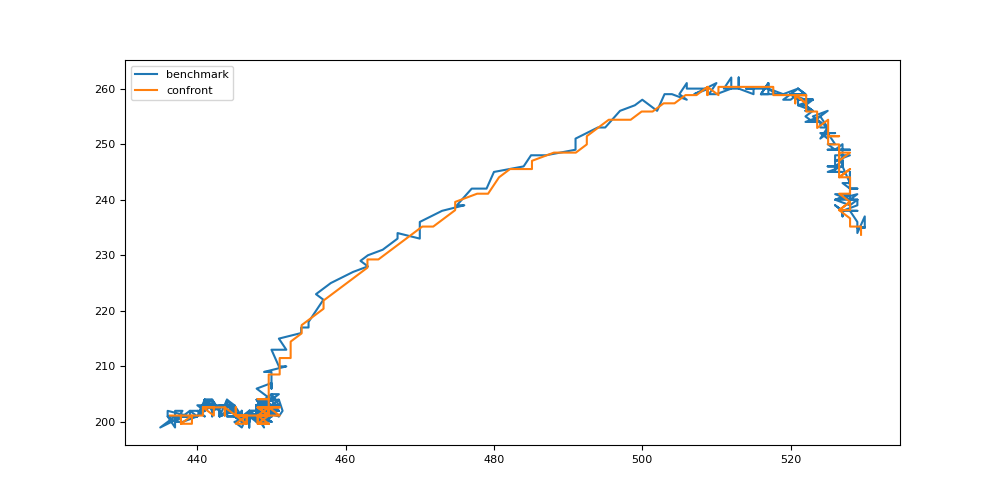

In [48]:
benchmark_traj = pd.read_csv(f"./results/error_estimation/benchmark_traj.csv")
startFrame = 18300
endFrame = 18900
benchmark_particle_id = 40
analyze_result(benchmark_traj, hough_trackpy_df, startFrame, endFrame, benchmark_particle_id)